In [237]:
%matplotlib inline

import matplotlib.pyplot as pyplot
import geopandas as gpd
import pandas as pd
import numpy as np
import copy

import shapely.geometry as geom
import shapely.affinity as affine
import shapely.wkt as wkt

from weave_units import WeaveUnit
from tile_units import TileUnit

## Normalising tile units
Have to ensure TileUnits consist only of whole elements

In [238]:
# unit = WeaveUnit(aspect = 5/6, margin = 0.0, strands = "abc|de")
# unit.elements.plot(column = "element_id", figsize = (30, 6))

In [270]:
d = 300
unit = TileUnit(spacing = d, crs = 3857)

R = d / 2 / np.cos(np.pi / 8)
angles = [np.pi / 8 + a * np.pi / 4 for a in range(8)]

octagon = geom.Polygon([(R * np.cos(a), R * np.sin(a)) for a in angles])
square_fragments = (
    unit.tile.geometry.difference(
        octagon).explode(index_parts = False, ignore_index = True))

fragments = gpd.GeoSeries([octagon] + list(square_fragments))
fragments = fragments.buffer(-1e-6).buffer(1e-6).apply(
    wkt.dumps, rounding_precision = 6).apply(wkt.loads)
fragments = gpd.GeoSeries([f.simplify(1e-6) for f in list(fragments)])
fragments_gdf = gpd.GeoDataFrame(
    data = {"fragment_id" : [0, 1, 1, 1, 1],
            "element_id" : list("abbbb")}, crs = 3857,
    geometry = fragments
)
unit.elements = fragments_gdf

<AxesSubplot:title={'center':'element_id'}>

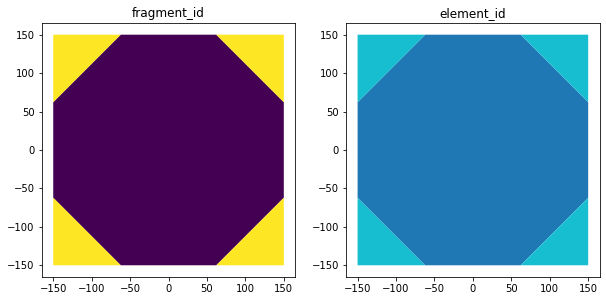

In [271]:

fig = pyplot.figure(figsize = (10, 5))
ax = fig.add_subplot(121, title = "fragment_id")
unit.elements.plot(ax = ax, column = "fragment_id")
ax = fig.add_subplot(122, title = "element_id")
unit.elements.plot(ax = ax, column = "element_id")


In [272]:
unit.elements

,fragment_id,element_id,geometry
0,0,a,"POLYGON ((150.000 62.132, 150.000 -62.132, 62...."
1,1,b,"POLYGON ((150.000 -150.000, 150.000 -150.000, ..."
2,1,b,"POLYGON ((150.000 150.000, 150.000 150.000, 15..."
3,1,b,"POLYGON ((-150.000 150.000, -150.000 150.000, ..."
4,1,b,"POLYGON ((-150.000 -150.000, -150.000 -150.000..."


Get width and height of the tile unit and hence translation vectors for copies.

In [273]:
bb = unit.tile.geometry[0].bounds
w = bb[2] - bb[0]
h = bb[3] - bb[1]
w, h
vectors = [(dx, dy) 
           for dx in (w, 0) 
           for dy in (0, h) 
           if not (dx == 0 and dy == 0)]
vectors

[(300.0, 0), (300.0, 300.0), (0, 300.0)]

For each unique fragment_id get the set of objects and attempt to dissolve them into a single object

In [274]:
def get_upper_rightmost_index(shapes):
    x_plus_y = [s.bounds[2] + s.bounds[3] for s in shapes]
    return x_plus_y.index(max(x_plus_y))


def merge_fragments(
        fragments:list[geom.Polygon],
        vectors:list[tuple]) -> list[geom.Polygon]:
    if len(fragments) == 1:
        return fragments
    anchor_index = get_upper_rightmost_index(fragments)
    anchor = fragments[anchor_index]
    other_fragments = fragments[:anchor_index] + fragments[(anchor_index + 1):]
    changes_made = True
    while len(other_fragments) > 0 and changes_made:
        changes_made = False
        to_remove = []
        for frag in other_fragments:
            if not (frag in to_remove):
                for v in vectors:
                    trans_frag = affine.translate(frag, v[0], v[1])
                    if anchor.distance(trans_frag) < 1e-3:
                        anchor = anchor.union(trans_frag).simplify(1e-6)
                        to_remove.append(frag)
                        changes_made = True
        for p in to_remove:
            if p in other_fragments:
                other_fragments.remove(p)
    return [anchor] + other_fragments


In [275]:
def normalise_tile_unit(tile_unit, v):
    elements = []
    normed_unit = copy.copy(tile_unit)
    ids = list(set(tile_unit.elements.fragment_id))
    for id in ids:
        fragment_set = list(
            tile_unit.elements[
                tile_unit.elements.fragment_id == id].geometry)
        elements.extend(merge_fragments(fragment_set, v))
    new_elements = tile_unit.elements
    new_elements.geometry = gpd.GeoSeries(elements) 
    normed_unit.elements = new_elements
    return normed_unit

In [276]:
norm_unit = normalise_tile_unit(unit, vectors)

<AxesSubplot:>

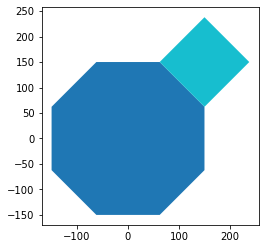

In [277]:
norm_unit.elements.plot(column = "element_id")